# Mall Customer Segmentation Dataset

(https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

Table of Contents:

1. Data Analysis
    - Data Description
    - Data Loading and Cleanup
    - Exploratory Data Analysis (EDA)
        - Correlation Heatmap
        - Relationship between variables
        - Distribution Plots
        - Box Plots
        - Count Plots grouped by Gender
    - Statistical Tests
    - Data Preprocessing
2. Machine Learning
    - KMeans Algorithm
    - Elbow Method
3. Conclusions

## Data Analysis

### Data Description

This dataset purports to represent customer data collected by a shopping mall administration team. The dataset consists of 200 rows and 5 columns.

The 5 columns are:
- CustomerID (numeric)
- Gender (numeric)
- Age (numeric)
- Anuual income (k$)
- Spending score (1-100),

and each row represents a customer.

### Data Loading and Cleanup

In [113]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import seaborn as sns
sns.set_theme(style='ticks')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, skew, ttest_ind, f_oneway

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

from sklearn.cluster import KMeans

In [114]:
#Create DataFrame object
df = pd.read_csv("Mall_Customers.csv")

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [116]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [117]:
#Checking for null-values
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [118]:
#Checking for duplicates
df.duplicated().sum()

0

In [119]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [120]:
#Reindexing
df.set_index('CustomerID', inplace=True); df

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [148]:
numerical_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
categorical_columns = ['Gender']

In [122]:
#Removing outliers outside of the 0.05-0.95 quantile range for all numerical categories
def remove_outliers_percentile(df, numerical_columns):
    for i,col in enumerate(df[numerical_columns]):
        min_threshold = df[col].quantile(0.05)
        max_threshold = df[col].quantile(0.95)
        df = df[(df[col] <= max_threshold) & (df[col] >= min_threshold)]
    return df

In [123]:
#Testing the outlier removal function
df_removed_outliers = remove_outliers_percentile(df,numerical_columns)
print(f'Shape of data before outlier removal: {df.shape}\nShape of data after outlier removal: {df_removed_outliers.shape}')

Shape of data before outlier removal: (200, 4)
Shape of data after outlier removal: (153, 4)


The outlier removal has been successful.

In [124]:
df = df_removed_outliers

### Exploratory Data Analysis

In [125]:
df[numerical_columns].corr()

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,0.030811,-0.388542
Annual Income (k$),0.030811,1.000000,-0.028389
Spending Score (1-100),-0.388542,-0.028389,1.000000


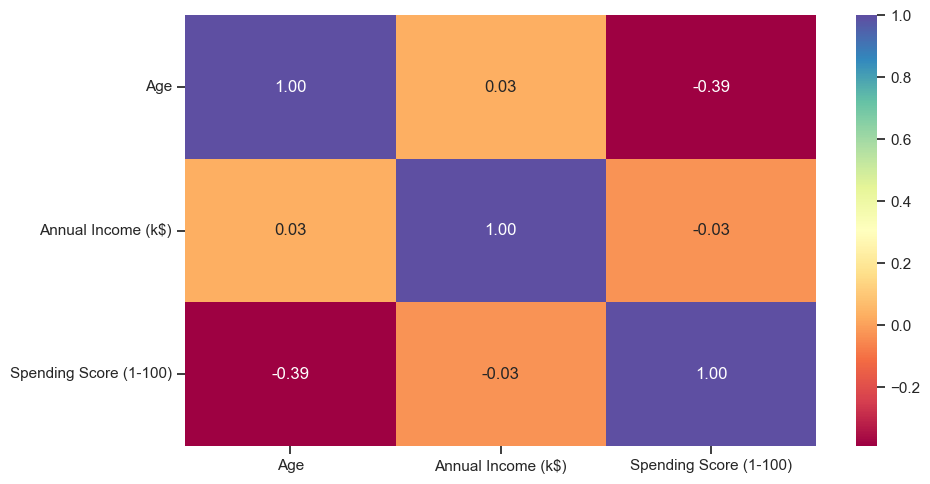

In [126]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(df[numerical_columns].corr(), cmap='Spectral', annot=True, fmt='.2f')
plt.tight_layout()
plt.savefig('images/01_Heatmap.png', bbox_inches='tight')
plt.show()

There is no significant correlation in the data. There is a weak negative correlation between a customer's Age and Spending Score with a Pearson's correlation coefficient of only -0.39.

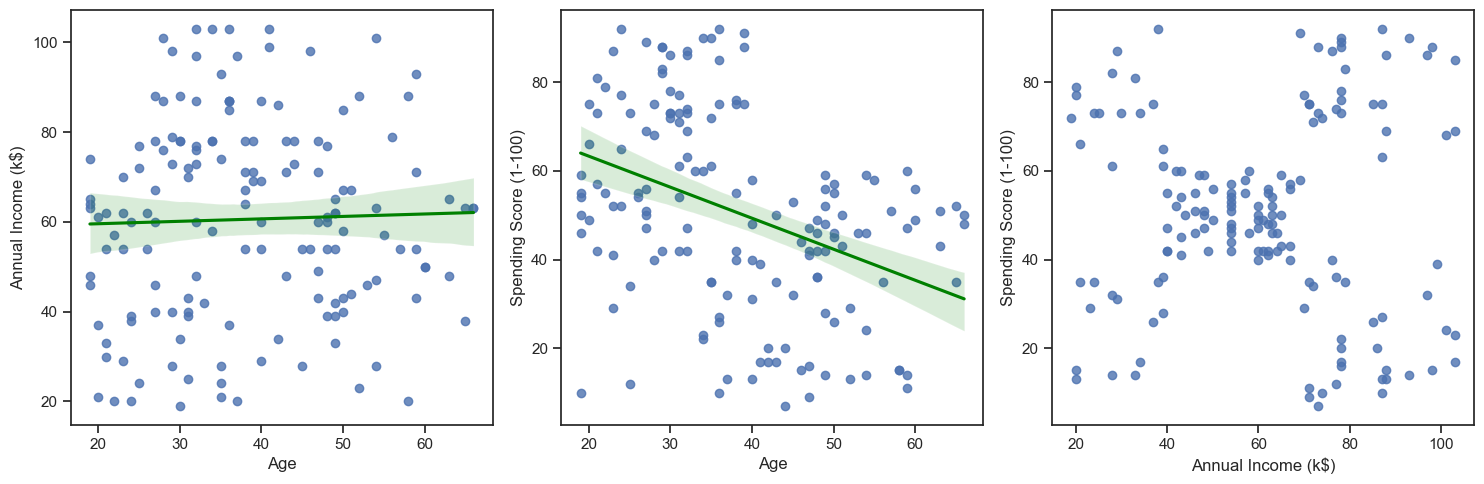

In [127]:
#Relational Plots
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)

sns.regplot(data=df, x='Age', y='Annual Income (k$)', ax=ax[0], fit_reg=True, line_kws={'color':'green'})
sns.regplot(data=df, x='Age', y='Spending Score (1-100)', ax=ax[1], fit_reg=True, line_kws={'color':'green'})
sns.regplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', ax=ax[2], fit_reg=False, line_kws={'color':'green'})
plt.tight_layout()
plt.savefig('images/01_Relational_plots.png', bbox_inches='tight')
plt.show()

The final relational plot is very interesting. It exhibits cluster patterns that divide customers into groups according their Annual Income and Spending Score. We see visible 5 clusters/segments of our customer base:
- People with relatively high annual income who spend a lot
- People with relatively high annual income who spend little
- People with relatively low annual income who spend a lot
- People with relatively low annual income who spend little
- People with average annual income who spend moderately

It would be more profitable for a Shopping Mall to sell products that are designed for only one of these customer groups (clusters) than to sell a product that would fall somewhere in between clusters in view of its price.

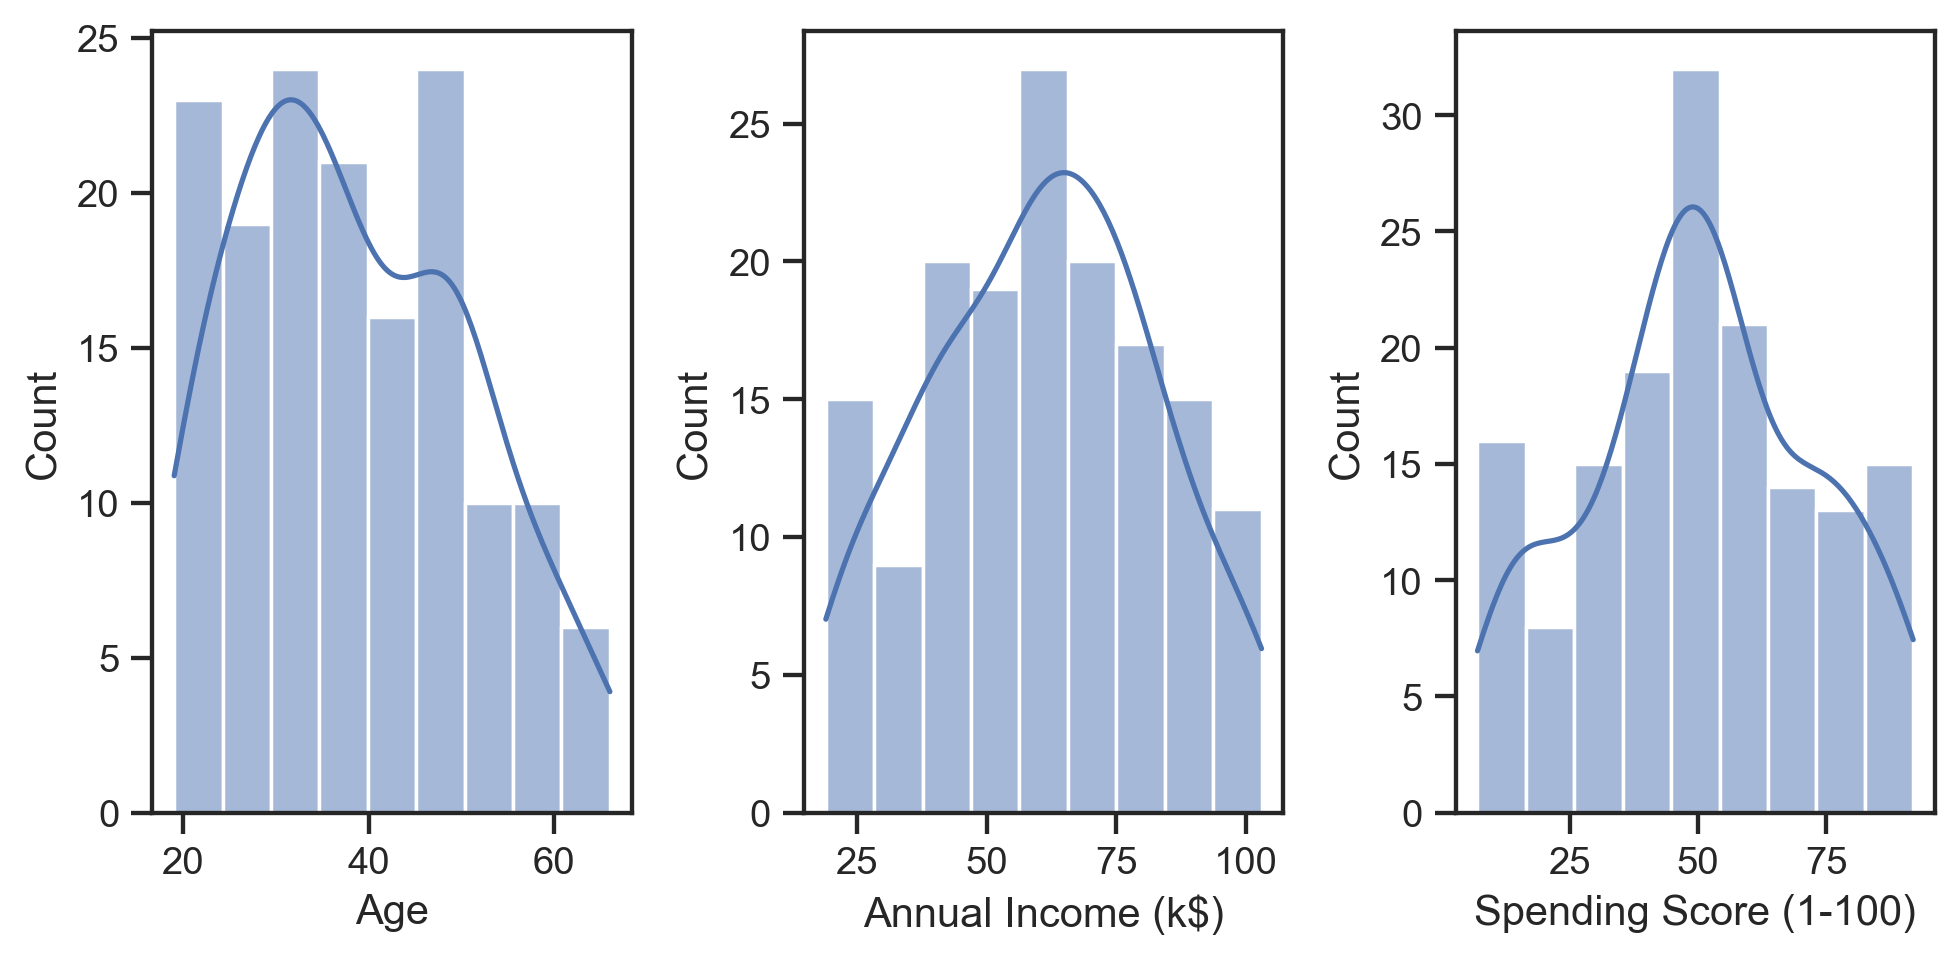

In [128]:
#Distribution plots
fig = plt.figure(figsize=(8,4), dpi=250)
for i,col in enumerate(numerical_columns):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=col, kde=True)
plt.tight_layout()
plt.savefig('images/01_Distributions.png', bbox_inches='tight')
plt.show()

The Age distribution plot is revealing a certain amount of skewness

In [129]:
df['Age'].skew()

0.32716854478297347

... which is still more than acceptable.

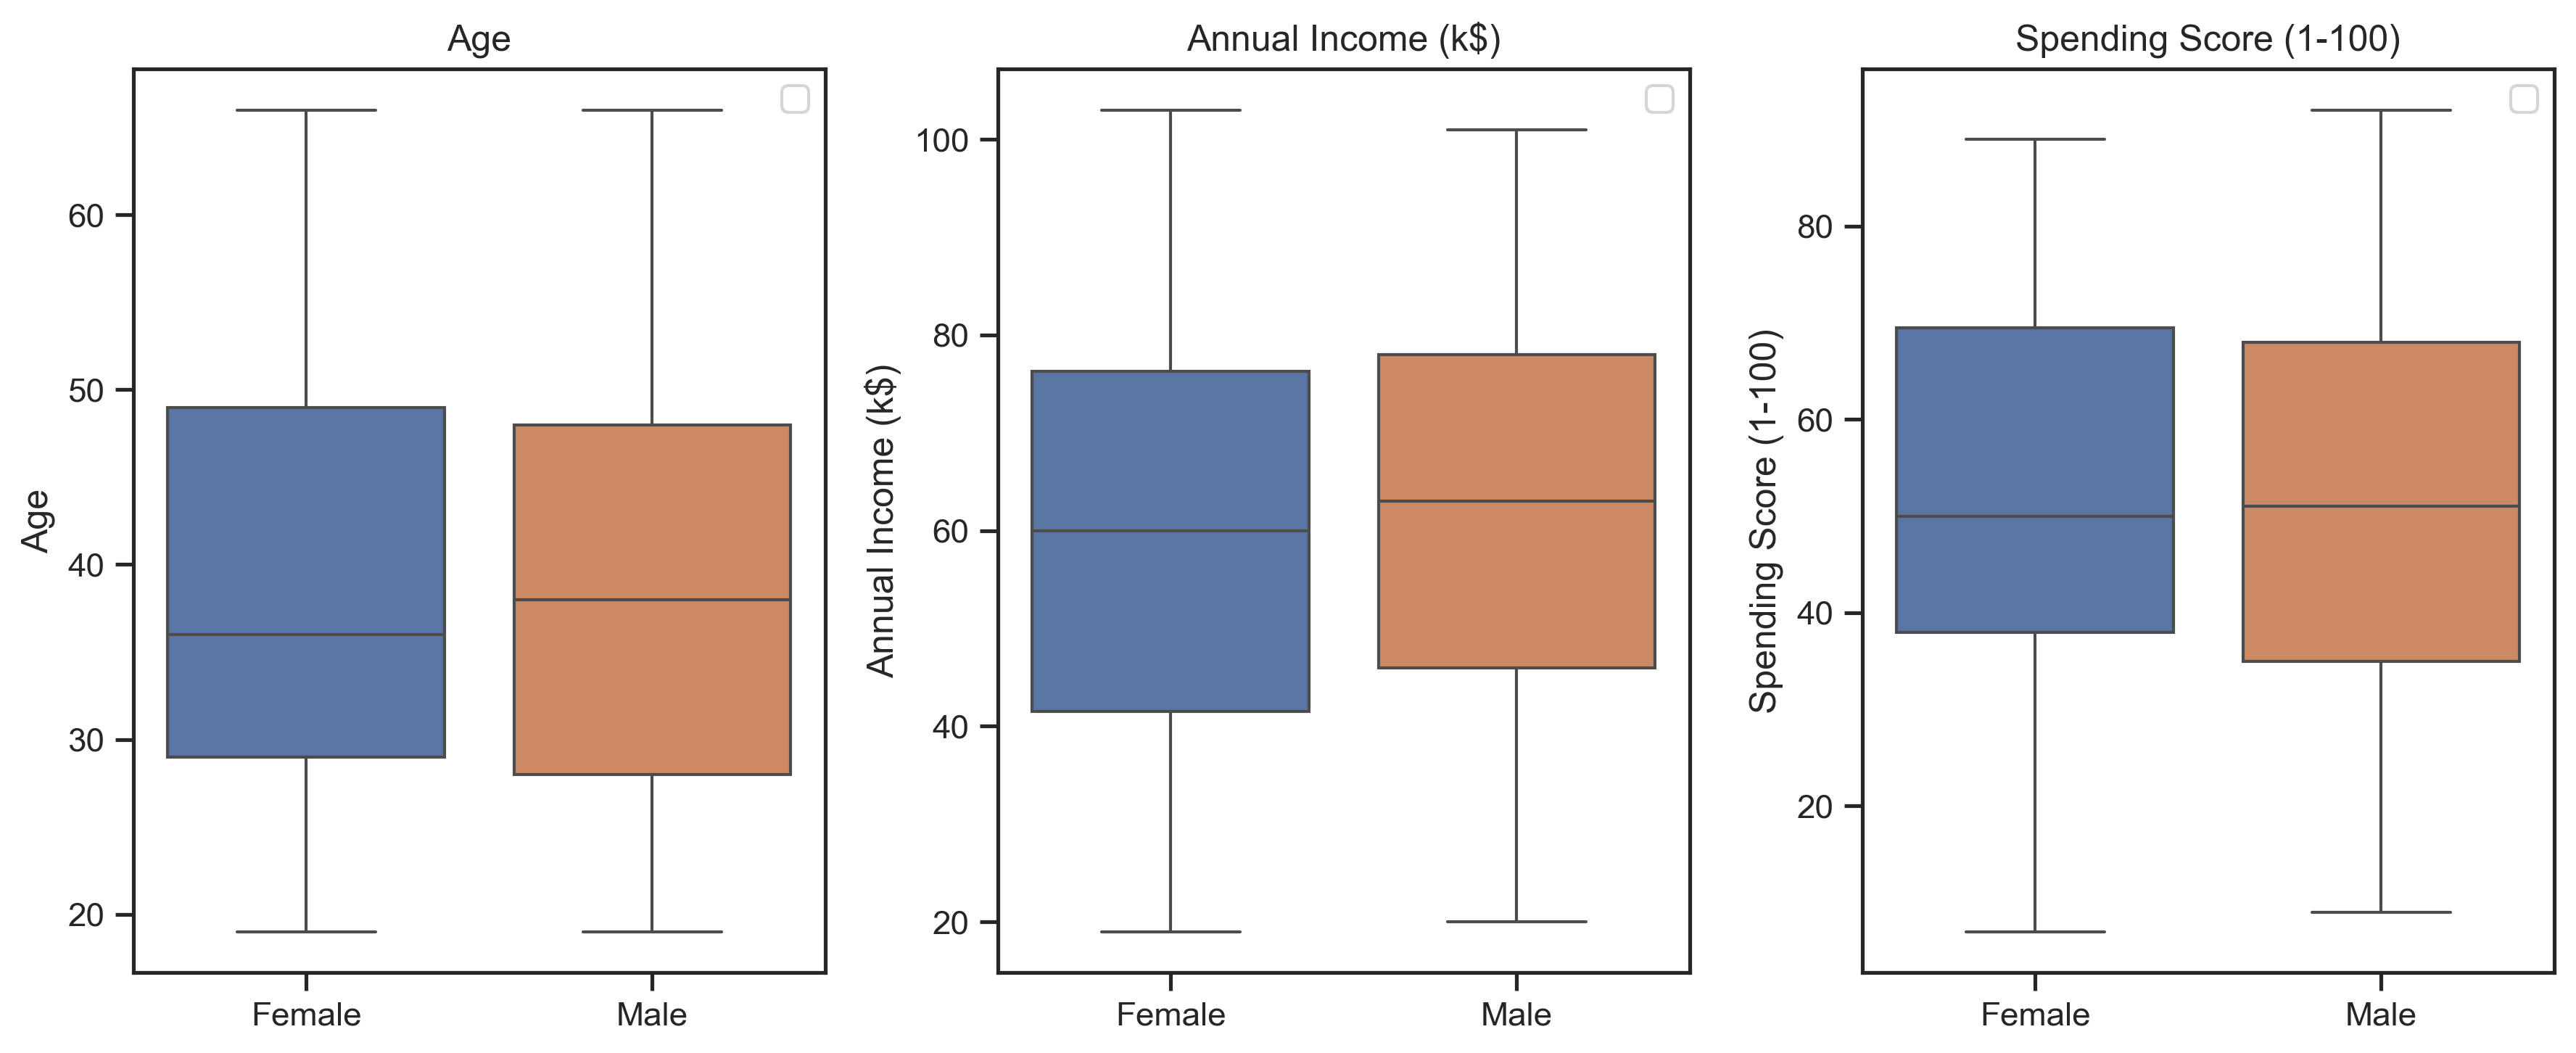

In [130]:
#Boxplots for numerical data
fig = plt.figure(figsize=(12,5), dpi=300)
for i, col in enumerate(numerical_columns):
    plt.subplot(1,3, i+1)
    sns.boxplot(x='Gender', y=col, data=df, hue='Gender')
    plt.legend('')
    plt.xlabel('')
    plt.ylabel(f'{col}')
    plt.title(f'{col}')

plt.tight_layout()
plt.savefig('images/01_Boxplots.png', bbox_inches='tight')
plt.show()

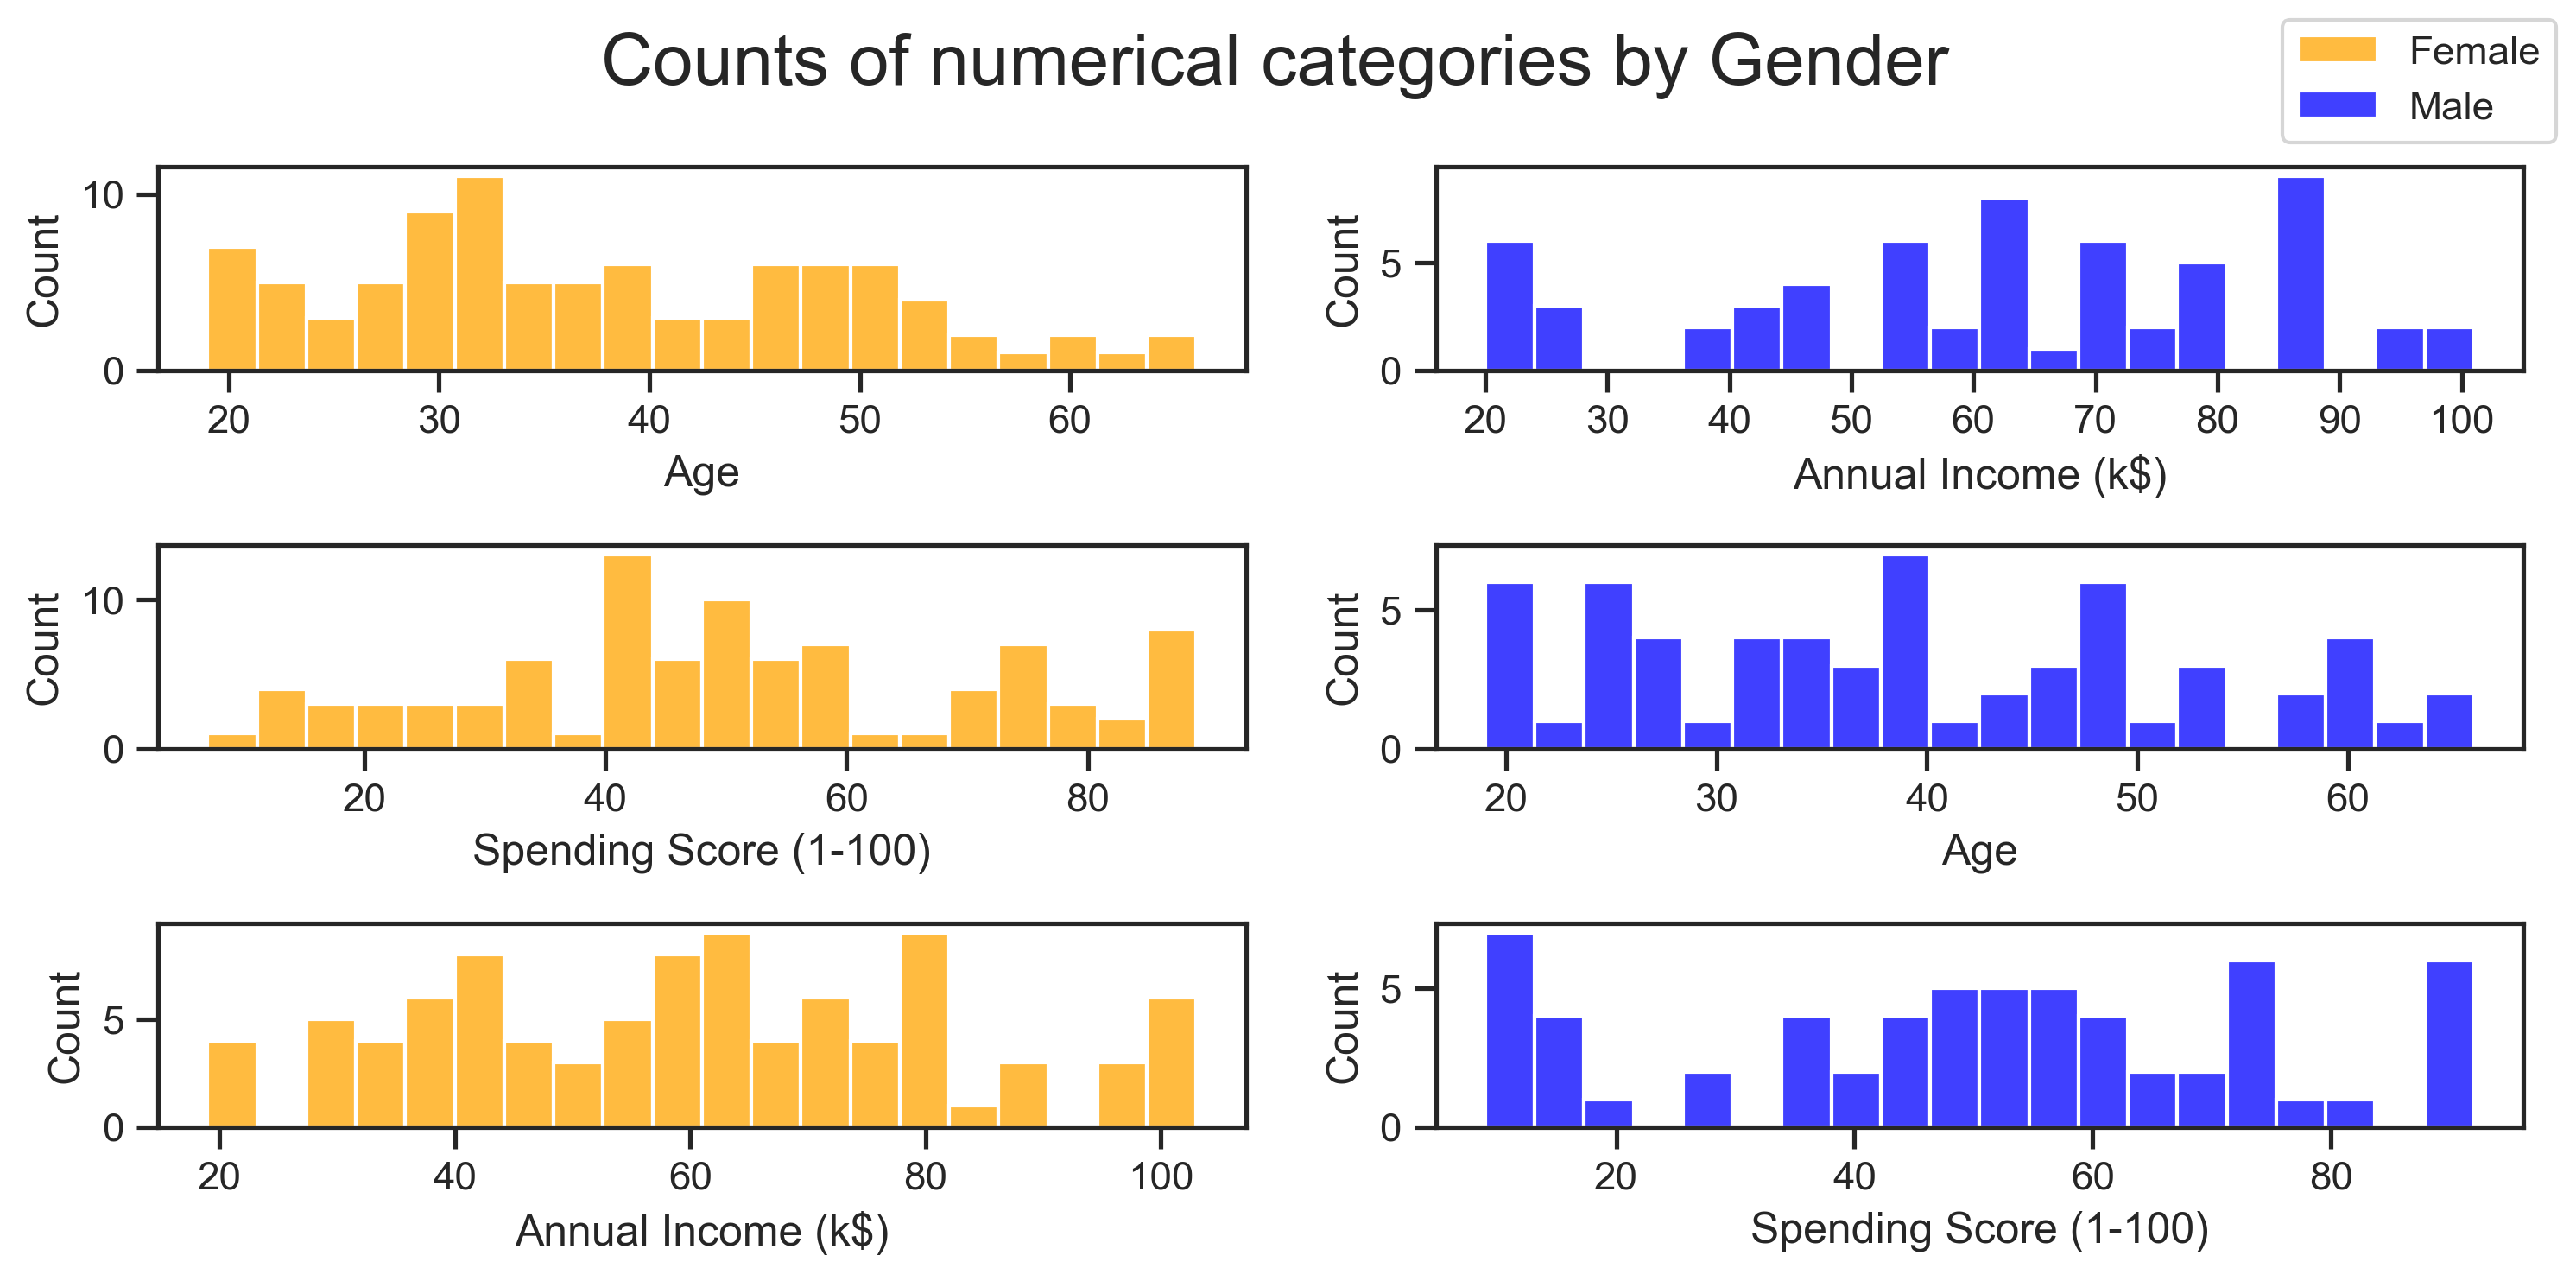

In [131]:
#Countplots
fig = plt.figure(figsize=(10,5), dpi=300)
df_male = df[df['Gender']=='Male']
df_female = df[df['Gender']=='Female']
for i,col in enumerate(numerical_columns*2):
    if (i+1)%2==0:
        plt.subplot(3, 2, i+1)
        sns.histplot(data=df_male, x=col, bins=20, color='blue')
    else:
        plt.subplot(3, 2, i+1)
        sns.histplot(data=df_female, x=col, bins=20, color='orange')
plt.savefig('images/01_Countplots_Gender.png', bbox_inches='tight')
plt.suptitle('Counts of numerical categories by Gender', fontsize=20)
plt.tight_layout()
fig.legend(labels=['Female','Male'])
plt.show()

### Statistical tests

When looking at the box-plots above, one is uncertain as to whether the differences in the median lines for Age, Annual Income and Spending Score bear any actual statistical significance. To find out, we will employ an ANOVA hypothesis test with a confidence level of 95%.

In [159]:
#ANOVA test for numerical features grouped by gender
print('---------------------------------------------------------------------------\nANOVA test for numerical features goruped by Gender (95% condfidence level)\n---------------------------------------------------------------------------')
for num_col in numerical_columns:
    for cat_col in categorical_columns:
        unique_groups = df[cat_col].unique()
        if len(unique_groups) > 1:
            groups = [df[df[cat_col]==group][num_col] for group in unique_groups]
            f_stat, p_value = f_oneway(*groups)
            print(f'ANOVA for {num_col} grouped by {cat_col}:\n F-statistic = {f_stat}, p-value={p_value}, Statistical significance: {'Yes' if p_value < 0.05 else 'No'}')

---------------------------------------------------------------------------
ANOVA test for numerical features goruped by Gender (95% condfidence level)
---------------------------------------------------------------------------
ANOVA for Age grouped by Gender:
 F-statistic = 0.33908828017289994, p-value=0.5612244223261676, Statistical significance: No
ANOVA for Annual Income (k$) grouped by Gender:
 F-statistic = 0.12229657095557399, p-value=0.7270441606334626, Statistical significance: No
ANOVA for Spending Score (1-100) grouped by Gender:
 F-statistic = 0.023725626129873317, p-value=0.8777907671920774, Statistical significance: No


The ANOVA hypothesis test indicates no statistical significance for numerical features of Age, Annual Income and Spending Score when grouped by Gender.

### Data Preprocessing

In [132]:
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

## Machine Learning

### KMeans Algorithm

In [133]:
kmeans_ = KMeans(n_clusters=5, random_state=44)

In [134]:
OMP_NUM_THREADs=1

In [135]:
y_predicted = kmeans_.fit_predict(df[['Annual Income (k$)', 'Spending Score (1-100)']])

c:\Users\jom4n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [136]:
y_predicted

array([2, 3, 2, 3, 2, 3, 2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 3, 2, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1])

In [137]:
df_results = df.copy()
df_results['Cluster'] = y_predicted
df_results

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
CustomerID,,,,,
10,Female,0.234043,0.000000,0.764706,2
13,Female,0.829787,0.011905,0.094118,3
14,Female,0.106383,0.011905,0.823529,2
15,Male,0.382979,0.011905,0.070588,3
16,Male,0.063830,0.011905,0.847059,2
...,...,...,...,...,...
188,Male,0.191489,0.976190,0.717647,1
189,Female,0.468085,1.000000,0.117647,0
190,Female,0.361702,1.000000,0.917647,1


<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

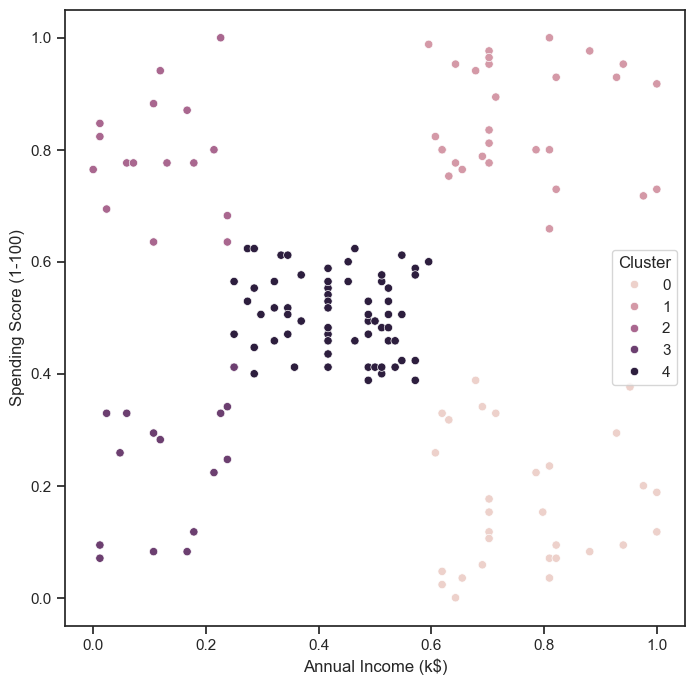

In [146]:
fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=df_results, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster')

The KMeans Algorithm has sucessfully grouped the data points into 5 different clusters. As mentioned before, each cluster represents a customer group with different incomes and spending habits.

Retreiving the Cluster centroids (centers) allows us to find the average value of Annual Income and Spending Score for each cluster, respectively.

In [139]:
centers = kmeans_.cluster_centers_
for i in range (centers.shape[0]):
    print(f'The center of cluster {i} is at coordinates: ({centers[i][0]},{centers[i][1]})')


The center of cluster 0 is at coordinates: (0.7692939244663382,0.1695740365111562)
The center of cluster 1 is at coordinates: (0.7549261083743841,0.8531440162271803)
The center of cluster 2 is at coordinates: (0.11904761904761896,0.7926470588235295)
The center of cluster 3 is at coordinates: (0.1406249999999999,0.2441176470588235)
The center of cluster 4 is at coordinates: (0.43461829176114886,0.5066293183940243)


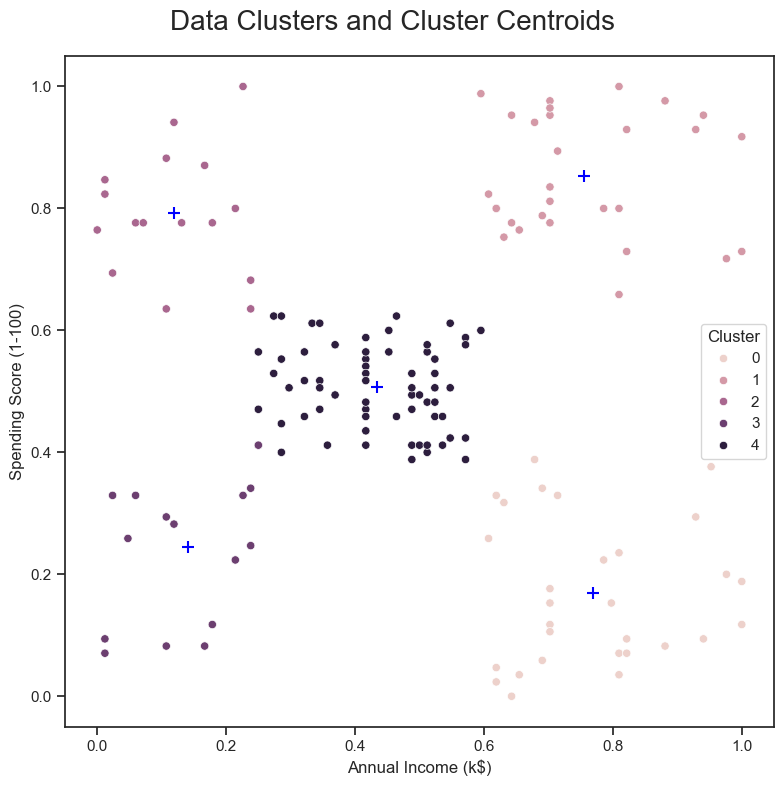

In [140]:
#Plotting clusters with centers
fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=df_results, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster')
plt.scatter(x=centers[:,0], y=centers[:,1], marker='+', s=85, color = 'blue')
plt.savefig('images/01_Clusters.png', bbox_inches='tight')
plt.suptitle('Data Clusters and Cluster Centroids', fontsize=20)
plt.tight_layout()
plt.show()

### Elbow Method

c:\Users\jom4n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jom4n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jom4n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jom4n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

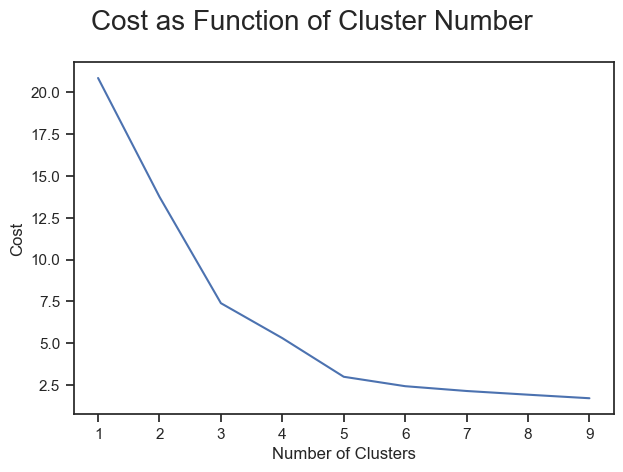

In [145]:
#Plotting the KMeans Cost Function as a function of the Number of Clusters
krange=range(1,10)
cost = []
for k in krange:
    km = KMeans(n_clusters=k)
    y = km.fit_predict(df[['Annual Income (k$)', 'Spending Score (1-100)']])
    cost.append(km.inertia_)
sns.lineplot(x=krange, y=cost)
plt.savefig('images/01_ElbowMethod.png', bbox_inches='tight')
plt.suptitle('Cost as Function of Cluster Number', fontsize=20)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.tight_layout()
plt.show()

In this case, the "Elbow Method" is moderately indicative of k=5 being the optimal number of clusters. This aligns with our own intution.

## Conclusion

We can sum up our findings into a few short bullet points:
- The Annual Income and Spending Score data categories exhibit high clustering tendencies
- The KMeans algorithm sucessfully groups customers into 5 distinct categories according to their low, moderate or high Annual Income or Spending Score
- The cluster centroids indicate average values for Annual Income and Spending Score inside a particular customer segment
- The Elbow Method agrees with our intution of there being exactly 5 clusters in the data